**Installing the necessary packages**

In [6]:
!pip install --quiet tensorflow==2.7.0

     |████████████████████████████████| 665.5 MB 22 kB/s 


In [11]:
!pip install tensorflow-quantum==0.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importing the necessary packages**

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# **Data preprocessing**

In [2]:
# Loading the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# Normalizing the data
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

**Function to keep only digit 3 and digit 6**

In [5]:
def keep_only_3_and_6(a, b):
    keep = (b == 3) | (b == 6)
    a, b = a[keep], b[keep]
    b = b == 3
    return a,b

In [6]:
x_train, y_train = keep_only_3_and_6(x_train, y_train)
x_test, y_test = keep_only_3_and_6(x_test, y_test)


**Seeing an example**

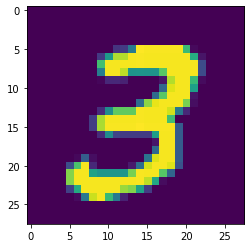

In [7]:
plt.imshow(x_train[0, :, :, 0])

**Function to resize**

In [8]:
def resize_to_4_x_4(dataset, size):
  return tf.image.resize(dataset, size).numpy()

In [10]:
x_train_resized = resize_to_4_x_4(x_train, (4,4))
x_test_resized = resize_to_4_x_4(x_test, (4,4))

True


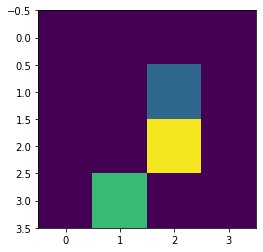

In [11]:
print(y_train[0])

plt.imshow(x_train_resized[0,:,:,0], vmin=0, vmax=1)

**Remove conradictory examples**

In [12]:
def remove_contradicting_images(xs, ys):

    # In the end "mapping" will hold the number of unique images
    mapping = collections.defaultdict(set)
    orig_x = {}

    # Establish the labels for each individual image.:
    for x,y in zip(xs,ys):
      orig_x[tuple(x.flatten())] = x
      mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []

    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Images that match multiple labels are discarded
          pass

    # Number of unique images of digit 3
    unique_images_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)

    # Number of unique images of digit 6
    unique_images_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    return np.array(new_x), np.array(new_y)

In [ ]:
x_train_no_contradicting, y_train_no_contradicting = remove_contradicting_images(x_train_resized, y_train)

# **Converting images to quantum circuits**

**Applying threshold**

In [15]:
# As this is a binary classifier, thereshold is 0.5
threshold = 0.5

x_train_binary = np.array(x_train_no_contradicting > threshold, dtype=np.float32)
x_test_binary = np.array(x_test_resized > threshold, dtype=np.float32)

In [16]:
def convert_image_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    image_values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    quantum_circuit = cirq.Circuit()
    for i, value in enumerate(image_values):
        if value:
            quantum_circuit.append(cirq.X(qubits[i]))
    return quantum_circuit


x_train_circuit = [convert_image_to_circuit(x) for x in x_train_binary]
x_test_circuit = [convert_image_to_circuit(x) for x in x_test_binary]

**Training data's quantum circuit**

Training data:


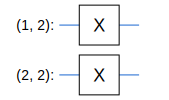

In [17]:
print("Training data:")
SVGCircuit(x_train_circuit[1])

**Testing data's quantum circuit**

Test data:


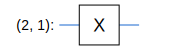

In [18]:
print("Test data:")
SVGCircuit(x_test_circuit[1])

**Convert to tensors**

In [19]:
x_train_tensors = tfq.convert_to_tensor(x_train_circuit)
x_test_tensors = tfq.convert_to_tensor(x_test_circuit)

# **Quantum Neural Network Model**

In [23]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout_qubit):
        self.data_qubits = data_qubits
        self.readout_qubit = readout_qubit

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout_qubit)**symbol)

**Create a sample circuit**

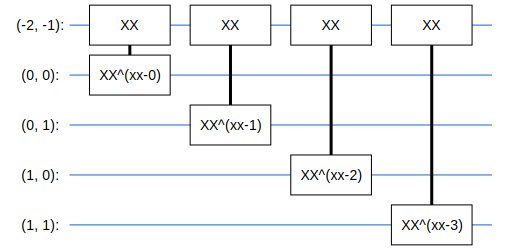

In [25]:
sample_circuit = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(2,2),
                                   readout_qubit=cirq.GridQubit(-2,-1))

quantum_circuit = cirq.Circuit()
sample_circuit.add_layer(quantum_circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(quantum_circuit)

**Create circuit for QNN**

In [26]:
def create_quantum_model():
    """This function creates a QNN model circuit and the necessary operations."""
    data_qubits = cirq.GridQubit.rect(4, 4)        # a 4x4 grid.
    readout_qubit = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    quantum_circuit = cirq.Circuit()

    # Preparing the readout qubit.
    quantum_circuit.append(cirq.X(readout_qubit))
    quantum_circuit.append(cirq.H(readout_qubit))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout_qubit=readout_qubit)

    # Adding layers
    builder.add_layer(quantum_circuit, cirq.XX, "xx1")
    builder.add_layer(quantum_circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    quantum_circuit.append(cirq.H(readout_qubit))

    return quantum_circuit, cirq.Z(readout_qubit)

In [27]:
model_circuit, model_readout = create_quantum_model()

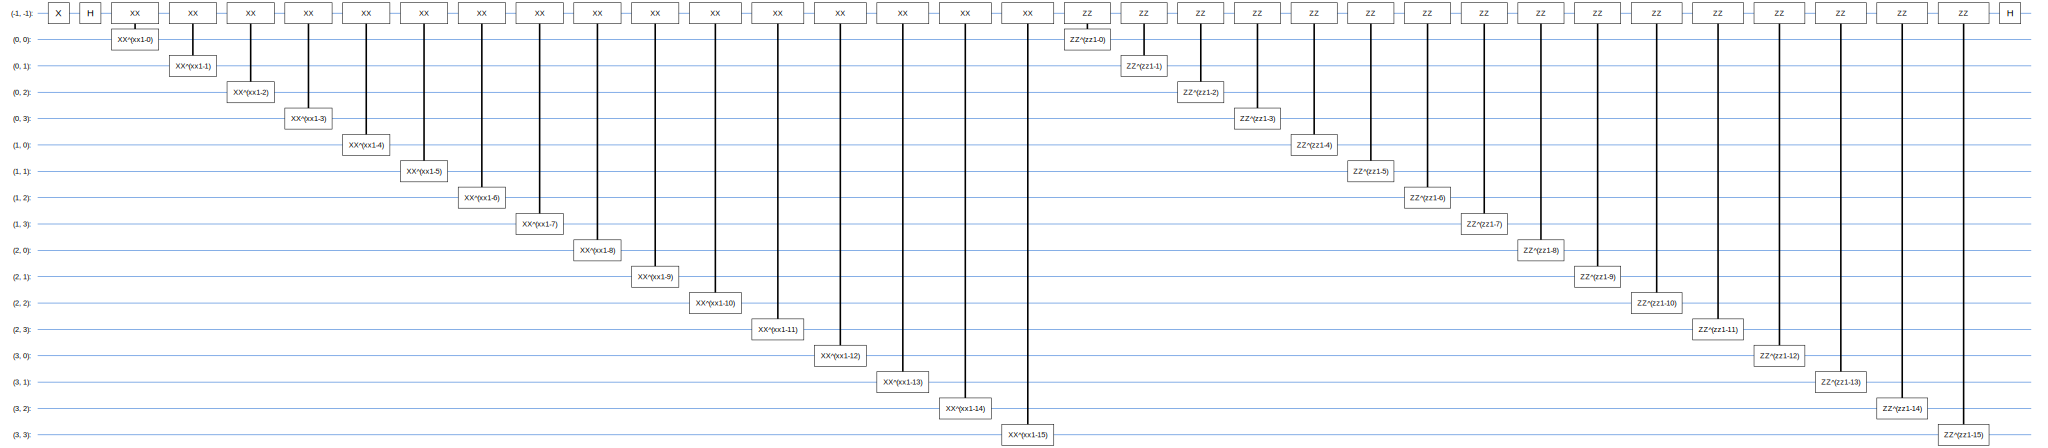

In [28]:
SVGCircuit(model_circuit)

**Build the Keras model**

In [29]:
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, model_readout),
])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


**Converting from True/False to [-1, 1]**

In [33]:
y_train_hinge = 2.0*y_train_no_contradicting-1.0
y_test_hinge = 2.0*y_test-1.0

**Hinge accuracy**

In [35]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

**Compiling the model**

In [37]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

# **Training the model**

In [45]:
qnn_history = model.fit(
      x_train_tensors, y_train_hinge,
      batch_size=32,
      epochs=10,
      verbose=1,
      validation_data=(x_test_tensors, y_test_hinge))

Epoch 1/10
324/324 [==============================] - 724s 2s/step - loss: 0.3484 - hinge_accuracy: 0.8818 - val_loss: 0.3300 - val_hinge_accuracy: 0.9042
Epoch 2/10
324/324 [==============================] - 726s 2s/step - loss: 0.3465 - hinge_accuracy: 0.8807 - val_loss: 0.3280 - val_hinge_accuracy: 0.8745
Epoch 3/10
324/324 [==============================] - 723s 2s/step - loss: 0.3451 - hinge_accuracy: 0.8792 - val_loss: 0.3280 - val_hinge_accuracy: 0.9073
Epoch 4/10
324/324 [==============================] - 721s 2s/step - loss: 0.3452 - hinge_accuracy: 0.8906 - val_loss: 0.3307 - val_hinge_accuracy: 0.9088
Epoch 5/10
324/324 [==============================] - 723s 2s/step - loss: 0.3452 - hinge_accuracy: 0.8862 - val_loss: 0.3298 - val_hinge_accuracy: 0.9073
Epoch 6/10
324/324 [==============================] - 726s 2s/step - loss: 0.3451 - hinge_accuracy: 0.8926 - val_loss: 0.3274 - val_hinge_accuracy: 0.8740
Epoch 7/10
324/324 [==============================] - 730s 2s/step - l

**Evaluating the model**

In [46]:
qnn_results = model.evaluate(x_test_tensors, y_test)

print(qnn_results)

[0.32742077112197876, 0.9082661271095276]


**Accuracy**

In [49]:
accuracy = qnn_results[1] * 100
print("The accuracy of the model is: ", str(accuracy) + ' %')

The accuracy of the model is:  90.82661271095276 %
